# Actor-Critic Method

This code is an example using Advantage Actor-Critic Method (a.k.a., A2C) The code is modified from [this one](https://github.com/pytorch/examples/blob/main/reinforcement_learning/actor_critic.py). [This website](https://medium.com/towards-data-science/understanding-actor-critic-methods-931b97b6df3f) might also be useful as a future reference, although the code can be outdated. 

There are multiple Actor-Critic Methods, but here we focus on 


In [55]:
import sys
import gym
import numpy as np
import scipy.linalg

import torch
import torch.nn            as nn
import torch.optim         as optim
import torch.nn.functional as F
import matplotlib.pyplot   as plt

gamma = 0.90 
eps   = np.finfo( np.float32 ).eps

# Actor-Critic Neural Network.

We merge the two networks in a single class, although we can separate these two. Since we have merged the two Actor and Critic networks, they are updated in synchrony, and they also share the same state input.
A method which asynchronously updates the two networks are called the "Asynchronous Advantage Actor-Critic Method" (a.k.a. A3C), where the details are in [this website](https://medium.com/@shagunm1210/implementing-the-a3c-algorithm-to-train-an-agent-to-play-breakout-c0b5ce3b3405).

### Actor Network
The actor network maps state to action, hence the input is the number of states of the example, $n_s$ and the output is the number of actions $n_a$.

### Critic Network
The critic network maps state to a scalar real value, which is known to be the Value function $V^{\pi}(s)$.

### Advantage Value 



In [56]:
def Gt_calc( r_arr: np.ndarray, gamma: float = 1, is_normalize: bool = True ) :
    """
        This method uses vectors for the Gt array calculation.

        Args:
            [1] r_arr: an array of rewards for each time step. 

            [2] gamma: discount ratio, valued between 0 to 1. 
                       If gamma = 1, then there is no discount applied

            [3] is_print: a boolean value which determines whether to print out the computation time or not.

        Return:
            G_t: an array of discounted (or if gamma = 1, simple sum of) rewards
    """

    # Our Goal is to generate Gt_arr as follows:
    # Gt_arr = [ R1 + r x R2 + r^2 x R3 + ... + r^(N-1) x RN, R2 + r x R3 + ... + r^(N-2) x RN, ..., RN  ]
    # For this, we have to run the following operation. 
    # [1] Generate the following N x N matrix called tmp1
    #     |  1  r  r^2  r^3  ...  r^(N-1)   |
    #     |  0  1  r    r^2  ...  r^(N-2)   |
    #     |  0  0  1    r    ...  r^(N-3)   |
    #     |            ...                  |
    #     |  0  0  0                    1   |                
    # [REF] https://stackoverflow.com/questions/28705834/fastest-way-to-compute-upper-triangular-matrix-of-geometric-series-python
    # 
    # [2] Generate the following N x N matrix called tmp2
    #     |  R1  R2  R3  R4  ...  RN   |
    #     |  R1  R2  R3  R4  ...  RN   |
    #     |  R1  R2  R3  R4  ...  RN   |
    #     |                  ...        |
    #     |  R1  R2  R3  R4  ...  RN   |
    #
    # [3] Conduct a dot product (Hadamard Operator) between tmp1 and tmp2
    #     |  R1  r x R2  r^2 x R3  ...  r^(N-1) x RN   |
    #     |   0      R2  r^1 x R3  ...  r^(N-2) x RN   |
    #     |   0       0        R3  ...  r^(N-3) x RN   |
    #     |                        ...                 |
    #     |   0       0         0  ...           RN    |
    # [4] Take the sum along axis 01
    #     |  R1 + r x R2 + r^2 x R3 + ... + r^(N-1) x RN  |
    #     |           R2 + r^1 x R3 + ... + r^(N-2) x RN  |
    #     |                      R3 + ... + r^(N-3) x RN  |
    #     |                        ...                    |
    #     |                                           RN  |

    N = len( r_arr )

    tmp1 = scipy.linalg.toeplitz( gamma ** np.arange( N ), np.zeros( N ) ).T
    tmp2 = np.tile( r_arr ,( N,1 ) ) 
    
    Gt_arr = np.sum( tmp1 * tmp2, axis = 1 )

    if is_normalize: Gt_arr = ( Gt_arr - Gt_arr.mean( ) ) / ( Gt_arr.std( ) + eps )

    return Gt_arr

class ActorCritic( nn.Module ):
    """
        Implements both actor and critic in one model
    """
    def __init__( self, num_input, num_output, num_hidden  ):

        super( ActorCritic, self ).__init__(  )

        # Saving this for choosing the action.
        self.n_action = num_output

        # First layer : from input to hidden variable
        self.affine1 = nn.Linear( num_input, num_hidden )

        # Second Actor's layer
        self.actor_layer = nn.Linear( num_hidden, num_output )

        # Second Critic's layer
        self.critic_layer = nn.Linear( num_hidden, 1 )

        # Optimizer 
        self.optimizer = optim.Adam( self.parameters( ), lr = 0.003 )

    def forward( self, x ):
        """
            Forward of both actor and critic.

            Args:
                - Current State Vector

            Outputs:
                - [1] action_prob: The pi( . | s ) itself
                - [2] state_value: The value function V(s)
        """

        # Forward the 1st layer
        x = F.relu( self.affine1( x ) )

        # Actor: Chooses action to take from state s_t 
        action_prob = F.softmax( self.actor_layer( x ), dim = -1 )

        # Critic: evaluates being in the state s_t
        state_value = self.critic_layer( x )

        # return values for both actor and critic as a tuple of 2 values:
        # 1. a list with the probability of each action over the action space
        # 2. the value from state s_t 

        return action_prob, state_value.squeeze( )

    def get_action_and_values( self, state: np.ndarray ):
        """
            Args:
                [1] State vector

            Outputs:
                [1]   action: The action chosen from the distribution
                [2]    value: Value from forwarding the network.
                [3] log_prob: The log probability of the action distruction
        """
        state = torch.from_numpy( state ).float( )

        # Forwarding the network.
        prob_dist, value = self.forward( state )

        # The action to take (left or right)
        action = np.random.choice( self.n_action, p = prob_dist.detach( ).numpy( ) )

        # Log-probability
        log_prob = torch.log( prob_dist[ action ] )

        return action, value, log_prob

    def update_network( self, rewards, values, log_probs ):
        """
            Training code. Calculates actor and critic loss and performs backprop.

            Args:
                -   rewards: Given the trajectory, a list of rewards 
                -    values: Given the trajectory, there is a list of states, and for each state there is an associated value function
                - log_probs: Given the trajectory, we have a list of p(a|s). 
        """
        
        Gt_arr    = torch.tensor( Gt_calc( rewards, gamma, is_normalize = True ) ) 
        
        values    = torch.stack(    values, dim = 0  )
        log_probs = torch.stack( log_probs, dim = 0  )

        adv_arr   = torch.sub( Gt_arr, values )

        policy_losses = -torch.dot( log_probs, adv_arr.float( ) )
        value_losses  = F.smooth_l1_loss( values, Gt_arr, reduction = 'sum' )

        # reset gradients
        self.optimizer.zero_grad( )

        # sum up all the values of policy_losses and value_losses
        loss = policy_losses + value_losses 

        # perform backprop
        loss.backward( )
        self.optimizer.step()

        

# The Advantage Actor-Critic (A2C) Method


In [59]:
# Generate the gym of Cart-and-Pole
env = gym.make( 'CartPole-v1' ) 

# The number of states and actions are +4 and +2
ns  = env.observation_space.shape[ 0 ]
na  = env.action_space.n

# Add the Adam optimizer
a2c_nn    = ActorCritic( ns, na, 128 )
is_render = False

# The number of episodes
N_eps = 2000

num_steps     = [ ]
avg_numsteps  = []

all_rewards = [ ]

for i in range( N_eps ):

    # reset environment and episode reward
    state = env.reset()
    ep_reward = 0

    # for each episode, only run 9999 steps so that we don't 
    rewards   = []
    log_probs = [] 
    values    = []

    for t in range( 1000 ):

        # select action from policy
        if is_render: env.render( )

        action, value, log_prob  = a2c_nn.get_action_and_values( state )

        # Run one step
        new_state, reward, done, _ = env.step( action )

        rewards.append( reward )
        values.append( value )
        log_probs.append( log_prob )

        if done: 

            a2c_nn.update_network( rewards, values, log_probs )
            sum_rewards = sum( rewards )

            num_steps.append( t )
            avg_numsteps.append( np.mean( num_steps[ -10: ] ) )

            all_rewards.append( sum_rewards )
            
            sys.stdout.write( "episode: {}, total reward: {}, average_reward: {}, length: {}\n".format( i , np.round( sum_rewards, decimals = 3 ),  np.round( np.mean( all_rewards[ -10 : ] ), decimals = 3 ), t ) )
            break

        state = new_state

episode: 0, total reward: 18.0, average_reward: 18.0, length: 17
episode: 1, total reward: 11.0, average_reward: 14.5, length: 10
episode: 2, total reward: 13.0, average_reward: 14.0, length: 12
episode: 3, total reward: 15.0, average_reward: 14.25, length: 14
episode: 4, total reward: 16.0, average_reward: 14.6, length: 15
episode: 5, total reward: 52.0, average_reward: 20.833, length: 51
episode: 6, total reward: 18.0, average_reward: 20.429, length: 17
episode: 7, total reward: 38.0, average_reward: 22.625, length: 37
episode: 8, total reward: 81.0, average_reward: 29.111, length: 80
episode: 9, total reward: 17.0, average_reward: 27.9, length: 16
episode: 10, total reward: 89.0, average_reward: 35.0, length: 88
episode: 11, total reward: 11.0, average_reward: 35.0, length: 10
episode: 12, total reward: 18.0, average_reward: 35.5, length: 17
episode: 13, total reward: 14.0, average_reward: 35.4, length: 13
episode: 14, total reward: 23.0, average_reward: 36.1, length: 22
episode: 15

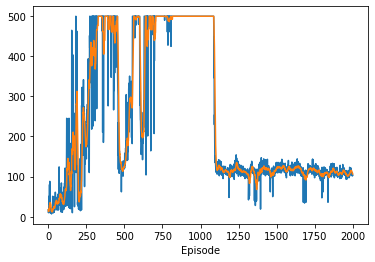

In [60]:
env.close( )
plt.plot( num_steps )
plt.plot( avg_numsteps )
plt.xlabel('Episode')
plt.show()

# References 

[1] [Great post](https://danieltakeshi.github.io/2018/06/28/a2c-a3c/)
[2] [Google Co-lab example](https://colab.research.google.com/github/yfletberliac/rlss-2019/blob/master/labs/DRL.01.REINFORCE%2BA2C.ipynb#scrollTo=xDifFS9I4X7A)